In [4]:
from surrogate_model.GPRs import GPRs
import pandas as pd
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# file_name = 'LHS180_t1.xlsx'
# df_info = pd.read_excel(file_name, "info").fillna(np.nan).replace([np.nan], [None])
# df = pd.read_excel(file_name, "conv")
# QoI_direction = np.ones(len(df_info["QoI"]))
# for idx, (min, max) in enumerate(zip(df_info["minimize"], df_info["maximize"])):
#     if (min is None) and (max is not None): # if maximization
#         QoI_direction[idx] = -1.
#     elif (min is not None) and (max is None): # if minimization
#         pass
#     elif (min is None) and (max is None): # error: neither max nor min
#         raise Exception(f"Max/Min should be determined for {df_info['QoI'][idx]}")
#     elif (min is not None) and (max is not None): # error: neither max nor min
#         raise Exception(f"Max/Min cannot be performed simultaneously for {df_info['QoI'][idx]}")
#
# x_num = sum(word.count("DV") for word in list(df.columns)) # Number of design variables (calculated by how many times "DV" appeared in the indices' name)
# x_list = ["DV"+f"{i}" for i in range(x_num)]
# y_list = list(df_info["QoI"])
# train_size = int(df.shape[0] * 0.8) # 80% for the train data
#
# x = df[x_list].to_numpy()
# y = df[y_list].to_numpy()


In [19]:
class DDO(): # Data-Driven Optimization
    def __init__(self):
        pass
        # self.x, self.y = x, y
        # self.n_var = self.x.shape[1]
        # self.n_obj = self.y.shape[1]
        # kernel = ConstantKernel() * Matern(length_scale=[1.]*self.n_var, nu=2.5)
        # kernel = ConstantKernel() * RBF(length_scale=[1.]*self.n_var)
        # kernel = ConstantKernel() * RBF(length_scale=1.)
        # self.gpr_models = GPRs(kernel=kernel, n_restarts_optimizer=30, random_state=42, normalize_y=True)
        # self.pop = pop_size

    def read_excel(self, file_name = 'LHS180_t1.xlsx'):
        df_info = pd.read_excel(file_name, "info").fillna(np.nan).replace([np.nan], [None])
        df = pd.read_excel(file_name, "conv")
        self.QoI_direction = np.ones(len(df_info["QoI"]))
        for idx, (min, max) in enumerate(zip(df_info["minimize"], df_info["maximize"])):
            if (min is None) and (max is not None): # if maximization
                self.QoI_direction[idx] = -1.
            elif (min is not None) and (max is None): # if minimization
                pass
            elif (min is None) and (max is None): # error: neither max nor min
                raise Exception(f"Max/Min should be determined for {df_info['QoI'][idx]}")
            elif (min is not None) and (max is not None): # error: neither max nor min
                raise Exception(f"Max/Min cannot be performed simultaneously for {df_info['QoI'][idx]}")

        x_num = sum(word.count("DV") for word in list(df.columns)) # Number of design variables (calculated by how many times "DV" appeared in the indices' name)
        self.x_list = ["DV"+f"{i}" for i in range(x_num)]
        self.y_list = list(df_info["QoI"])
        self.train_size = int(df.shape[0] * 0.8) # 80% for the train data

        x = df[self.x_list].to_numpy()
        y = df[self.y_list].to_numpy()

        self.x, self.y = x, y
        self.n_var = self.x.shape[1]
        self.n_obj = self.y.shape[1]


    def shuffle(self):

        np.random.seed(42)
        # Data shuffling
        random_idx = np.arange(self.x.shape[0])
        np.random.shuffle(random_idx)
        x_shuffled, y_shuffled = self.x[random_idx], self.y[random_idx]

        # Train-Test split
        self.x_train, self.y_train = x_shuffled[:self.train_size], y_shuffled[:self.train_size]
        self.x_test, self.y_test = x_shuffled[self.train_size:], y_shuffled[self.train_size:]

        # Manual elimination of outliers
        self.x_train = np.delete(self.x_train, [14,50], axis=0)
        self.y_train = np.delete(self.y_train, [14,50], axis=0)

    def fit(self):

        kernel = ConstantKernel() * Matern(length_scale=[1.]*self.n_var, nu=2.5)
        # kernel = ConstantKernel() * RBF(length_scale=[1.]*self.n_var)
        # kernel = ConstantKernel() * RBF(length_scale=1.)
        self.gpr_models = GPRs(kernel=kernel, n_restarts_optimizer=30, random_state=42, normalize_y=True)
        self.gpr_models.fit(self.x_train, self.y_train)

    def predict(self, x=None):

        if x is None: # When the x for the prediction is not given, perform prediction with x_test datatset
            y_pred = self.gpr_models.predict(self.x_test)
        else:
            y_pred = self.gpr_models.predict(x)

        return y_pred

    def plot(self, y_true=None, y_pred=None, savefig=True):

        if y_true is None:
            y_true = self.y_test
        if y_pred is None: # If y_pred is not given, use the prediction from x_test as "y_pred"
            y_pred = self.predict()

        def make_plot(y_true, y_pred):
            sns.set_style("whitegrid")
            sns.set_palette("Set2")
            min_plt, max_plt = np.min([np.min(y_true), np.min(y_pred)]), np.max([np.max(y_true), np.max(y_pred)])
            min_show, max_show = min_plt - 0.1 * (max_plt - min_plt), max_plt + 0.1 * (max_plt - min_plt)
            fig, ax = plt.subplots(dpi=100)
            ax.scatter(y_true, y_pred, edgecolors='k')
            ax.plot([min_show, max_show], [min_show, max_show], '--k')
            ax.set_ylim(min_show, max_show)
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlabel("Ground truth", fontsize=17)
            ax.set_ylabel("Prediction", fontsize=17)
            ax.set_title(self.y_list[y_idx], fontsize=20)

            return fig, ax

        for y_idx in range(self.n_obj):

            y_true_ = y_true[:,y_idx]
            y_pred_ = y_pred[:,y_idx]
            fig, ax = make_plot(y_true_, y_pred_)
            if savefig:
                fig.savefig(f"figures/{self.y_list[y_idx]}")


    def optimize(self, pop_size=100):
        self.pop = pop_size

        problem = self.def_problem()
        algorithm, termination = self.def_algorithm()

        res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=False)
        self.res = res

        return res

    def def_problem(self):

        parent_cls = self
        class MyProblem(ElementwiseProblem):

            def __init__(self):
                super().__init__(n_var=parent_cls.n_var,
                                 n_obj=parent_cls.n_obj,
                                 xl=np.array([0]*parent_cls.n_var),
                                 xu=np.array([1]*parent_cls.n_var))

            def _evaluate(self, x, out, *args, **kwargs):
                f = np.hsplit(parent_cls.predict(x.reshape(1,-1)), indices_or_sections=parent_cls.n_obj)
                f = np.array(f).reshape(1,-1) * parent_cls.QoI_direction
                out["F"] = [f]

        problem = MyProblem()

        return problem

    def def_algorithm(self):

        algorithm = NSGA2(
            pop_size=self.pop,
            eliminate_duplicates=True
        )
        termination = get_termination("n_gen", 100)

        return algorithm, termination

    def print_opt_results(self, filename=""):
        # self.QoI_directions
        x_optimized = self.res.X
        y_optimized = self.res.F * self.QoI_direction
        write_data = pd.DataFrame(np.concatenate([x_optimized, y_optimized],axis=1))
        write_data.columns = self.x_list + self.y_list
        self.write_data = write_data
        write_data.to_excel(f"Pareto_{filename}.xlsx", index=False)

C:\Users\Woong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Woong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Woong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWar

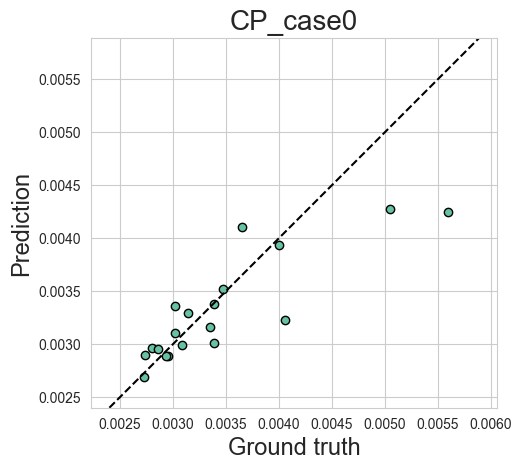

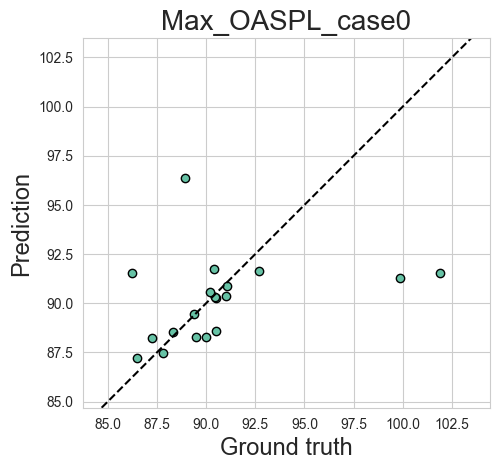

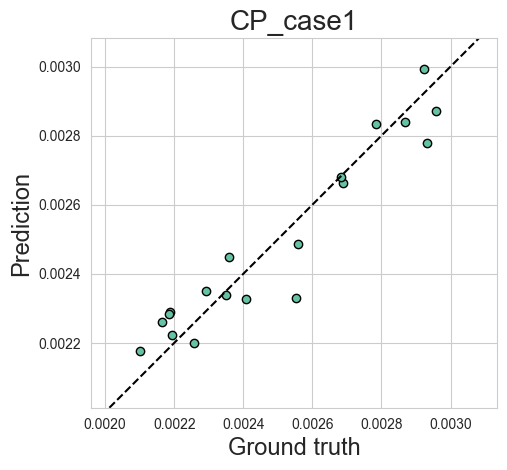

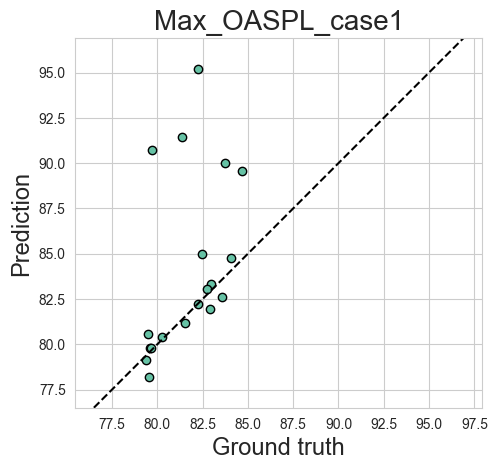

In [20]:
ddo = DDO()
ddo.read_excel(file_name = 'LHS180_t1.xlsx')
ddo.shuffle()
ddo.fit()
ddo.plot()
# for i in range(4):
#     fig, ax = ddo.plot(y_idx=i)
#     # fig, ax = ddo.plot(y_true=ddo.y_train[:,0], y_pred=ddo.predict(ddo.x_train)[:,0], y_idx=i)
#     ax.set_title(y_list[i], fontsize=20)
#     plt.show()

In [11]:
ddo.optimize()
ddo.print_opt_results()

In [10]:
# ddo.gpr_models.models
kernel = ConstantKernel() * Matern(nu=2.5)
asdf = GPRs(kernel=kernel, n_restarts_optimizer=30, random_state=42, normalize_y=True)
np.random.seed(42)
# Data shuffling
random_idx = np.arange(x.shape[0])
np.random.shuffle(random_idx)
x_shuffled, y_shuffled = x[random_idx], y[random_idx]

# Train-Test split
x_train, y_train = x_shuffled[:train_size], y_shuffled[:train_size]
x_test, y_test = x_shuffled[train_size:], y_shuffled[train_size:]

# Manual elimination of outliers
x_train = np.delete(x_train, [14,50], axis=0)
y_train = np.delete(y_train, [14,50], axis=0)

asdf.fit(x_train, y_train)
print(asdf.models[0].score(x_test,y_test[:,0]))

GPR()
[GPR()]
GPR()
[GPR(), GPR()]
GPR()
[GPR(), GPR(), GPR()]
GPR()
[GPR(), GPR(), GPR(), GPR()]
0.5654299047534508


In [9]:
x_optimized = opt_results.X
y_optimized = opt_results.F
write_data = pd.DataFrame(np.concatenate([x_optimized, y_optimized],axis=1))
write_data.columns = x_list + y_list
write_data.to_excel("Pareto.xlsx")